E:\python_prj\train\helper.py:228: SyntaxWarning: invalid escape sequence '\m'
  draw_loss("E:\\python_prj\\train\model\cnn_transformer\\log.txt")


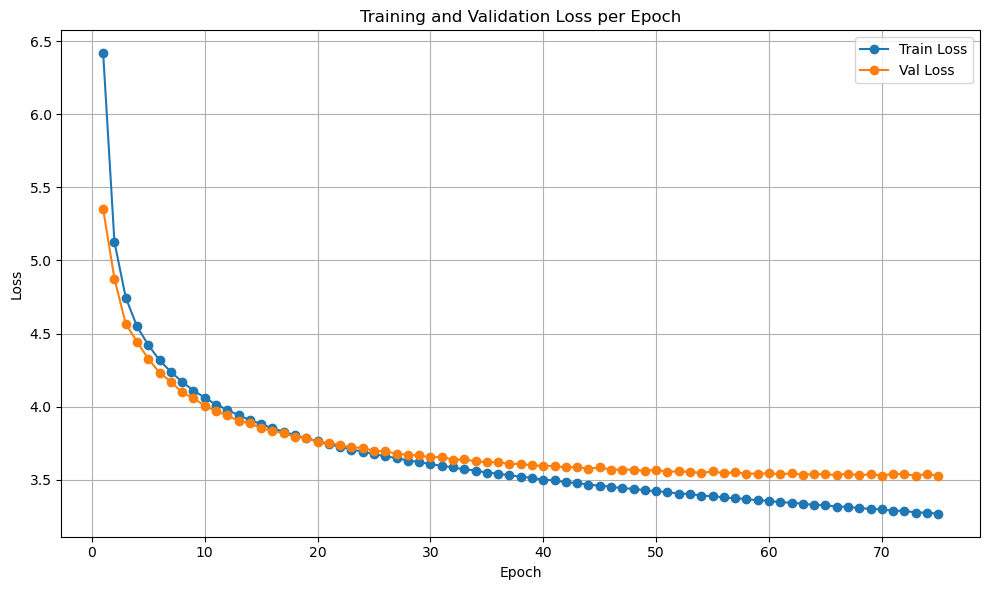

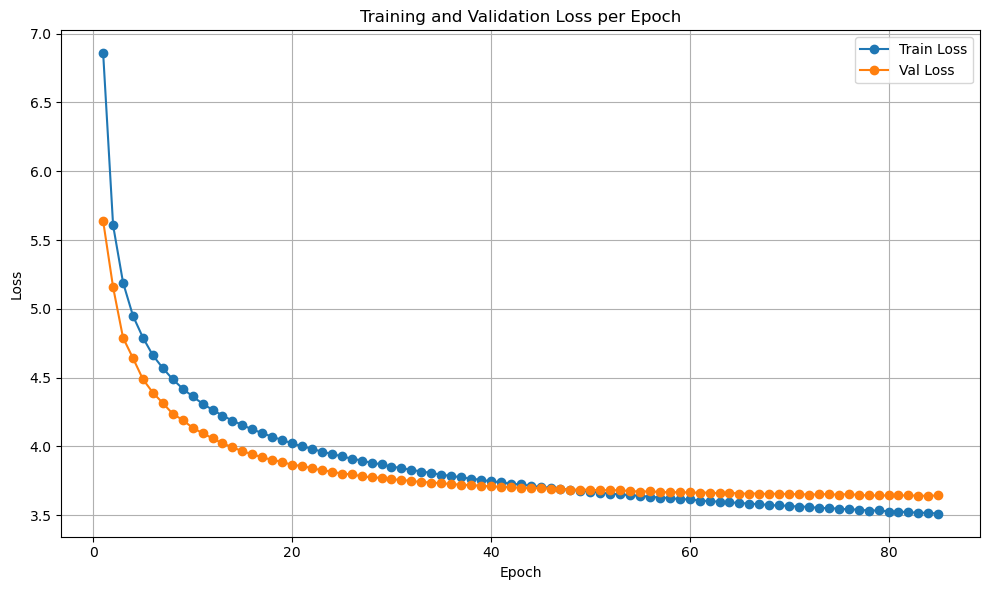

VIT(
  (encoder_vit): EncoderVIT(
    (patch_embedding): PatchEmbedding(
      (conv): Conv2d(3, 200, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder_blocks): ModuleList(
      (0-2): 3 x EncoderBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (layer_norm_1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=200, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=512, out_features=200, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
        (layer_norm_2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (embed_dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder_vit): DecoderVIT(
    (embeddin

In [1]:

from model.VIT import VIT
import os.path

from processing.image_processing import process_image
from settings import BASE_DIR
from train.helper import load_checkpoint

model_path = os.path.join(BASE_DIR, "train", "model","vit", "best_model.pth")
model, _, _ = load_checkpoint(VIT, model_path, 0.0001)
model



(process:736): Pango-WARNING **: 10:22:03.102: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:25092): Pango-WARNING **: 10:22:03.729: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:944): Pango-WARNING **: 10:22:04.166: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


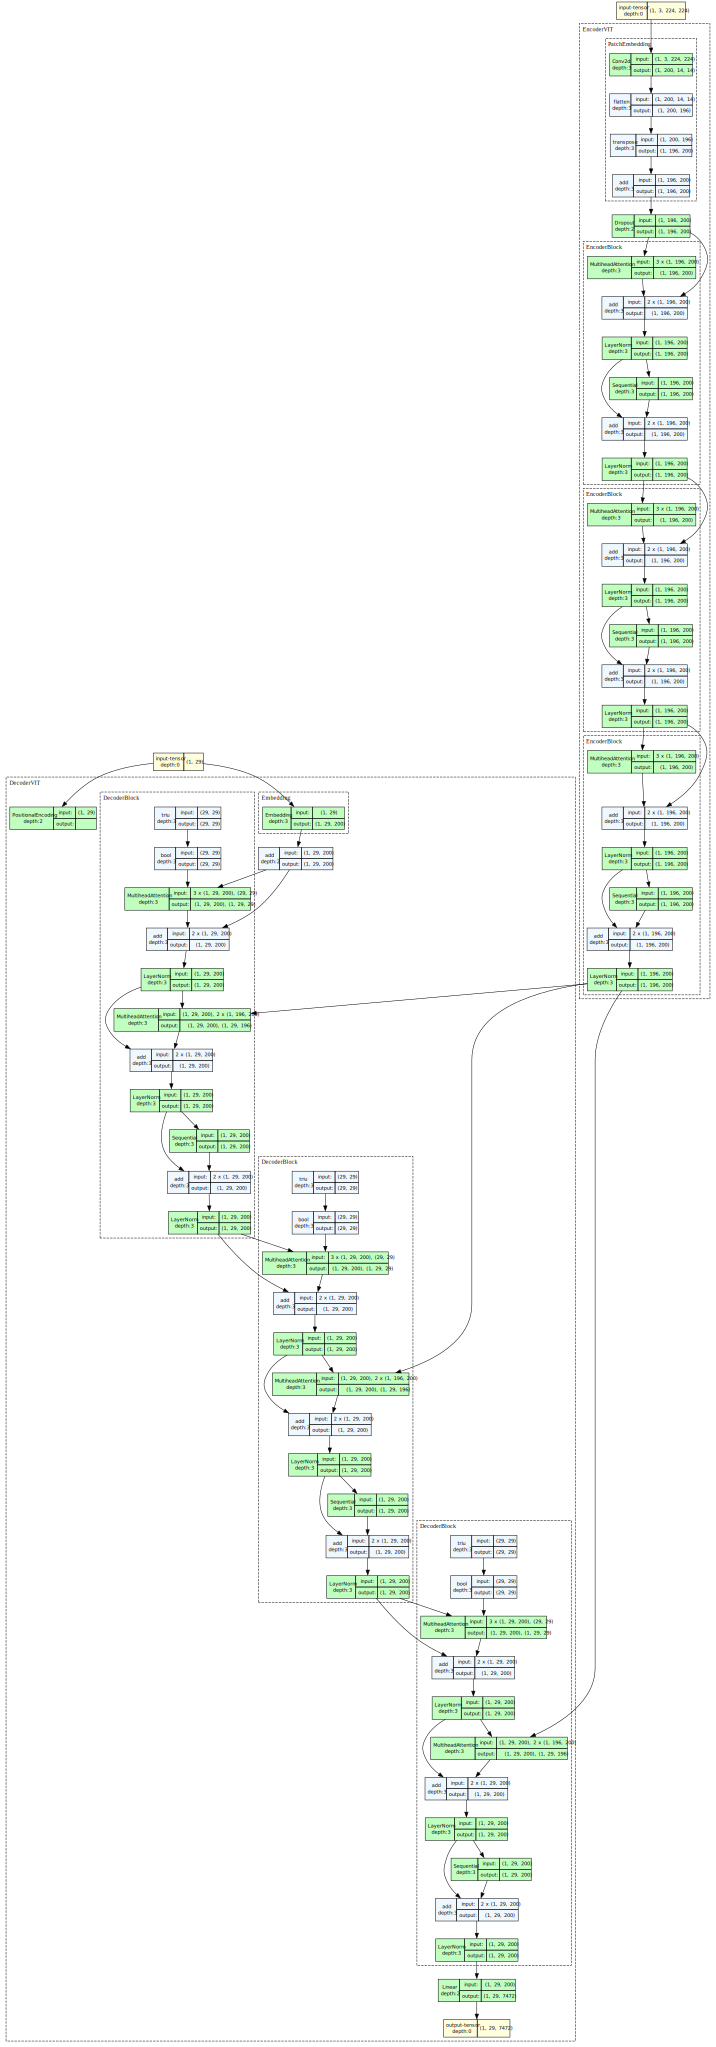

In [9]:
from dataset.flickr30k.Flickr30kDataset import Flickr30kDataset
from train.helper import collate_fn
from torchview import draw_graph
import torch
import pandas as pd
from PIL import Image
MAX_LEN = 30

test_path = os.path.join(BASE_DIR, "dataset" , "flickr30k", "test.csv")
vocab = model.vocab
test_dataset =  Flickr30kDataset(test_path,word2idx=vocab.w2i, max_length = MAX_LEN)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
transformed_image, input_sequences, target_sequences = test_dataloader.__iter__().__next__()




graph = draw_graph(
    model,
    input_data=(transformed_image, input_sequences),  # caption input for decoder
    expand_nested=True,
    show_shapes=True,
    save_graph=True,
    graph_name="VIT_model_graph",

)

graph.visual_graph.render(
    filename="VIT_model_graph",  # tên file đầu ra
    format="jpg",                    # định dạng: jpg
    directory=".",                   # thư mục lưu file
    cleanup=True                     # xóa file trung gian .dot
)
graph.visual_graph

In [4]:
from settings import DEVICE
import torch

vocab = model.vocab
print(vocab.vocab_size)
def generate_caption(model, image, vocab, max_len=40):
    model.eval()
    with torch.no_grad():
        image = image.to(DEVICE).unsqueeze(0)  # (1, 3, 224, 224)

        # Encode ảnh
        encoder_output = model.encoder_vit(image)

        # Khởi tạo caption đầu vào với <START>
        input_ids = [vocab.w2i["<START>"]]

        for _ in range(max_len):
            input_tensor = torch.tensor([input_ids], device=DEVICE)


            # Dự đoán từ tiếp theo
            output = model.decoder_vit(input_tensor, encoder_output)
            next_token_logits = output[0, -1, :]
            next_token = torch.argmax(next_token_logits).item()

            if next_token == vocab.w2i["<END>"]:
                break

            input_ids.append(next_token)

        # Chuyển token ID -> từ
        caption = [vocab.i2w[idx] for idx in input_ids[1:]]
        return " ".join(caption)

7472


In [5]:
from PIL import Image
from processing.image_processing import process_image
image = Image.open("E:\\python_prj\\dataset\\flickr30k\\flickr30k-images\\1007129816.jpg").convert("RGB")
image.show()
import time
start_time = time.time()
processed_image = process_image(image)
caption = generate_caption(model, processed_image, vocab)
print(caption)
end_time = time.time()
print(f"Time taken to generate caption: {end_time - start_time} seconds")

a man in a white shirt and a woman in a white shirt are sitting on a bench
Time taken to generate caption: 0.3828577995300293 seconds


In [6]:
predictions = []
references = []
import pandas as pd
test_df = pd.read_csv(os.path.join(BASE_DIR, "dataset" , "flickr30k", "test.csv"))
import time
start_time = time.time()
for index, row in test_df.iterrows():
    image = Image.open(row["image_path"]).convert("RGB")
    processed_image = process_image(image)
    caption = generate_caption(model, processed_image, vocab)
    predictions.append(caption)
    references.append(row["caption"])
end_time = time.time()
print(f"Time taken to generate caption: {(end_time - start_time)/len(predictions)} seconds")



Time taken to generate caption: 0.07521826376914978 seconds


In [7]:
import evaluate

bleu = evaluate.load("bleu")
# === Tính toán ===
bleu_result = bleu.compute(predictions=predictions, references=references)


# === In kết quả ===
print("BLEU:", bleu_result)



BLEU: {'bleu': 0.04600579448506702, 'precisions': [0.26633544354515587, 0.07216656503179719, 0.02370455196106499, 0.009832260787002849], 'brevity_penalty': 1.0, 'length_ratio': 1.0115756878131028, 'translation_length': 62395, 'reference_length': 61681}


In [22]:
meteor = evaluate.load("meteor")
meteor_result = meteor.compute(predictions=predictions, references=references)
print("METEOR:", meteor_result)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\huynh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\huynh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\huynh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR: {'meteor': 0.17983583378542836}


In [23]:
rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references)
print("ROUGE:", rouge_result)

ROUGE: {'rouge1': 0.2626811295303458, 'rouge2': 0.06979085488473463, 'rougeL': 0.24099241785757514, 'rougeLsum': 0.24119005268627136}
